# **Tier-1 Hexagonal Cell**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

keras = tf.keras

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [2]:
radius = 500

t = np.linspace(0, 2*math.pi, 7)

#center cell
x1 = []
y1 = []
for i in range(len(t)):
  x1.append(0 + radius*math.cos(t[i]))
  y1.append(0 + radius*math.sin(t[i]))

c_x1 = 0  #BS Location Center Cell x-axis
c_y1 = 0 #BS Location Center Cell y-axis


#upper cell
x2 = []
y2 = []
for i in range(len(t)):
  x2.append(0+radius*math.cos(t[i]))
  y2.append(((math.sqrt(3)/2)*2*radius) + (radius*math.sin(t[i])))

c_x2 = 0  #BS Location Upper Cell x-axis
c_y2 = ((math.sqrt(3)/2)*2*radius) #BS Location Upper Cell y-axis


#lower cell
x3 = []
y3 = []
for i in range(len(t)):
  x3.append(0+radius*math.cos(t[i]))
  y3.append(-((math.sqrt(3)/2)*2*radius) + (radius*math.sin(t[i])))

c_x3 = 0  #BS Location Lower Cell x-axis
c_y3 = -((math.sqrt(3)/2)*2*radius) #BS Location Lower Cell y-axis


#right upper cell
x4 = []
y4 = []
for i in range(len(t)):
  x4.append((radius+(radius/2)) + radius*math.cos(t[i]))
  y4.append(((math.sqrt(3)/2)*radius) + (radius*math.sin(t[i])))

c_x4 = (radius+(radius/2))  #BS Location right upper Cell x-axis
c_y4 = ((math.sqrt(3)/2)*radius) #BS Location right upper Cell y-axis


#%Right Lower cell
x5 = []
y5 = []
for i in range(len(t)):
  x5.append((radius+(radius/2)) + radius*math.cos(t[i]))
  y5.append(-((math.sqrt(3)/2)*radius) + (radius*math.sin(t[i])))

c_x5 = (radius+(radius/2))  #BS Location right lower Cell x-axis
c_y5 = -((math.sqrt(3)/2)*radius) #BS Location right lower Cell y-axis


#%Left Upper cell
x6 = []
y6 = []
for i in range(len(t)):
  x6.append(-(radius+(radius/2)) + radius*math.cos(t[i]))
  y6.append(((math.sqrt(3)/2)*radius) + (radius*math.sin(t[i])))

c_x6 = -(radius+(radius/2))  #BS Location Left upper x-axis
c_y6 = ((math.sqrt(3)/2)*radius) #BS Location Left upper y-axis


#left lower cell
x7 = []
y7 = []
for i in range(len(t)):
  x7.append(-(radius+(radius/2)) + radius*math.cos(t[i]))
  y7.append(-((math.sqrt(3)/2)*radius) + (radius*math.sin(t[i])))

c_x7 = -(radius+(radius/2)) #BS Location left lower Cell x-axis
c_y7 = -((math.sqrt(3)/2)*radius) #BS Location left lower Cell y-axis


BS_locations_x = [c_x1, c_x2, c_x3, c_x4, c_x5, c_x6, c_x7]    #centre, up, low, right up, right low, left up, left low
BS_locations_y = [c_y1, c_y2, c_y3, c_y4, c_y5, c_y6, c_y7]

X =np.array([x1,x2,x3,x4,x5,x6,x7])
Y =np.array([y1,y2,y3,y4,y5,y6,y7])

diff = [c_x4, c_y4] 
ISD = np.linalg.norm(diff)
print("ISD: ", ISD)

ISD:  866.0254037844386


[-1500, -1500, -1500, -750.0, -750.0, -2250.0, -2250.0]
[1732.0508075688772, 2598.0762113533156, 866.0254037844386, 2165.0635094610966, 1299.0381056766578, 2165.0635094610966, 1299.0381056766578]


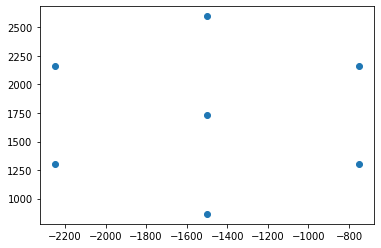

In [3]:
# ISD = sqrt(3)*RADIUS
isd = math.sqrt(3)*radius
BS2x = [x + (-3*radius) for x in BS_locations_x]
BS2y = [y + (2*isd) for y in BS_locations_y]

print(BS2x)
print(BS2y)
plt.scatter(BS2x, BS2y)
plt.show()

In [4]:
BS3x = [x + (1.5*radius) for x in BS_locations_x]
BS3y = [y + (2.5*isd) for y in BS_locations_y]

In [5]:
BS4x = [x + (4.5*radius) for x in BS_locations_x]
BS4y = [y + (0.5*isd) for y in BS_locations_y]

In [6]:
BS5x = [x + (3*radius) for x in BS_locations_x]
BS5y = [y + (-2*isd) for y in BS_locations_y]

In [7]:
BS6x = [x + (-1.5*radius) for x in BS_locations_x]
BS6y = [y + (-2.5*isd) for y in BS_locations_y]

In [8]:
BS7x = [x + (-4.5*radius) for x in BS_locations_x]
BS7y = [y + (-0.5*isd) for y in BS_locations_y]

In [9]:
BS_total_x = [BS_locations_x, BS2x, BS3x, BS4x, BS5x, BS6x, BS7x]
#print(BS_total_x)
BS_wrap_around_x = sum(BS_total_x, [])
print(BS_wrap_around_x)
print(np.shape(BS_wrap_around_x))

BS_total_y = [BS_locations_y, BS2y, BS3y, BS4y, BS5y, BS6y, BS7y]
BS_wrap_around_y = sum(BS_total_y, [])

[0, 0, 0, 750.0, 750.0, -750.0, -750.0, -1500, -1500, -1500, -750.0, -750.0, -2250.0, -2250.0, 750.0, 750.0, 750.0, 1500.0, 1500.0, 0.0, 0.0, 2250.0, 2250.0, 2250.0, 3000.0, 3000.0, 1500.0, 1500.0, 1500, 1500, 1500, 2250.0, 2250.0, 750.0, 750.0, -750.0, -750.0, -750.0, 0.0, 0.0, -1500.0, -1500.0, -2250.0, -2250.0, -2250.0, -1500.0, -1500.0, -3000.0, -3000.0]
(49,)


**x co-ordinates of Base Stations(all wrap around + sectors)**


In [10]:
BS_wrap_around_total3x = []
for i in BS_wrap_around_x:
  for j in range(3):
    BS_wrap_around_total3x.append(i)

print(BS_wrap_around_total3x,"\n", len(BS_wrap_around_total3x))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 750.0, 750.0, 750.0, 750.0, 750.0, 750.0, -750.0, -750.0, -750.0, -750.0, -750.0, -750.0, -1500, -1500, -1500, -1500, -1500, -1500, -1500, -1500, -1500, -750.0, -750.0, -750.0, -750.0, -750.0, -750.0, -2250.0, -2250.0, -2250.0, -2250.0, -2250.0, -2250.0, 750.0, 750.0, 750.0, 750.0, 750.0, 750.0, 750.0, 750.0, 750.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2250.0, 2250.0, 2250.0, 2250.0, 2250.0, 2250.0, 2250.0, 2250.0, 2250.0, 3000.0, 3000.0, 3000.0, 3000.0, 3000.0, 3000.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500.0, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 2250.0, 2250.0, 2250.0, 2250.0, 2250.0, 2250.0, 750.0, 750.0, 750.0, 750.0, 750.0, 750.0, -750.0, -750.0, -750.0, -750.0, -750.0, -750.0, -750.0, -750.0, -750.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1500.0, -1500.0, -1500.0, -1500.0, -1500.0, -1500.0, -2250.0, -2250.0, -2250.0, -2250.0, -2250.0, -2250.0, -2250.0, -2250.0, -2250.0, -1500.0, -1500.0, -1500.0, 

**y co-ordinates of Base Stations(all wrap around+sectors)**




In [11]:
BS_wrap_around_total3y = []
for i in BS_wrap_around_y:
  for j in range(3):
    BS_wrap_around_total3y.append(i)

print(BS_wrap_around_total3y,"\n", len(BS_wrap_around_total3y))

[0, 0, 0, 866.0254037844386, 866.0254037844386, 866.0254037844386, -866.0254037844386, -866.0254037844386, -866.0254037844386, 433.0127018922193, 433.0127018922193, 433.0127018922193, -433.0127018922193, -433.0127018922193, -433.0127018922193, 433.0127018922193, 433.0127018922193, 433.0127018922193, -433.0127018922193, -433.0127018922193, -433.0127018922193, 1732.0508075688772, 1732.0508075688772, 1732.0508075688772, 2598.0762113533156, 2598.0762113533156, 2598.0762113533156, 866.0254037844386, 866.0254037844386, 866.0254037844386, 2165.0635094610966, 2165.0635094610966, 2165.0635094610966, 1299.0381056766578, 1299.0381056766578, 1299.0381056766578, 2165.0635094610966, 2165.0635094610966, 2165.0635094610966, 1299.0381056766578, 1299.0381056766578, 1299.0381056766578, 2165.0635094610966, 2165.0635094610966, 2165.0635094610966, 3031.088913245535, 3031.088913245535, 3031.088913245535, 1299.038105676658, 1299.038105676658, 1299.038105676658, 2598.076211353316, 2598.076211353316, 2598.07621

In [12]:
BS_cor_x = np.array(BS_wrap_around_total3x)
print(BS_cor_x.shape)

BS_cor_y = np.array(BS_wrap_around_total3y)
print(BS_cor_y.shape)

(147,)
(147,)


# Function to generate(nums) amount of users in each sector

In [13]:
def GetSecusers(nums):
  
  xy_all = np.zeros((3*nums, 2))
  for j in range(7):
    count = 0
    m = 0
    p2 = np.zeros((nums,2)) 
    hk = np.array([BS_locations_x[j],BS_locations_y[j]])

    while(count<3):
      a = np.array([X[j, 0+m] - BS_locations_x[j], Y[j, 0+m] - BS_locations_y[j]])
      b = np.array([X[j, 2+m] - BS_locations_x[j], Y[j, 2+m] - BS_locations_y[j]])
      p = []
      for i in range(nums):
        u1 = np.random.uniform(0,1)                
        u2 = np.random.uniform(0,1)  
        p.append(u1*a + u2*b)
      p = np.array(p+hk)
      angle_cord= p - hk
      angles = np.arctan2(angle_cord[:,1], angle_cord[:,0])  #np.arctan2(y, x)


      if(count==0):
        p2 = p
        angles2 = angles
      else:
        p2 = np.concatenate((p2, p),axis=0)
        angles2 = np.concatenate((angles2, angles),axis=0)
      m+=2
      count+=1

    #CLUB ALL Base station users
    if(j==0):
      xy_all = p2
      angles_all = angles2
    else:
      xy_all = np.concatenate((xy_all, p2), axis=0)
      angles_all = np.concatenate((angles_all, angles2),axis=0)  

  n_users, nu = np.shape(xy_all)
  #print(np.shape(xy_all))
  #print(n_users)

  return n_users, xy_all[:,0], xy_all[:,1]
    

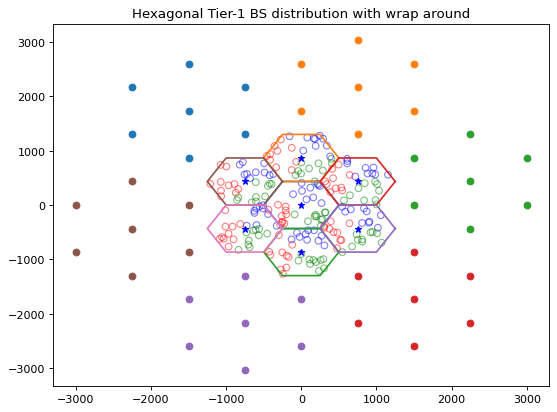

In [14]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)


numm = 10
total_user, xs, ys= GetSecusers(numm)
plt.plot(x1,y1)
plt.plot(x2,y2)                                                                 
plt.plot(x3,y3)
plt.plot(x4,y4)
plt.plot(x5,y5)
plt.plot(x6,y6)
plt.plot(x7,y7)
plt.plot(BS_locations_x,BS_locations_y,'b*')    

plt.scatter(BS2x, BS2y)
plt.scatter(BS3x, BS3y)
plt.scatter(BS4x, BS4y)
plt.scatter(BS5x, BS5y)
plt.scatter(BS6x, BS6y)
plt.scatter(BS7x, BS7y)

plt.title('Hexagonal Tier-1 BS distribution with wrap around')
                                                                                
for i in range(7):
  k =(3*numm)*i
  plt.scatter(xs[k:k+numm], ys[k:k+numm], edgecolor='b', facecolor='none', alpha=0.5)
  plt.scatter(xs[k+numm:k+2*numm], ys[k+numm:k+2*numm], edgecolor='r', facecolor='none', alpha=0.5)
  plt.scatter(xs[k+2*numm:k+3*numm], ys[k+2*numm:k+3*numm], edgecolor='g', facecolor='none', alpha=0.5)


plt.show()

In [15]:
def PlotSecUsers(n_users, xs, ys):
  
  plt.plot(x1,y1)   #x,x2,x3,...,x7 are hex cell boundary         
  plt.plot(x2,y2)              
  plt.plot(x3,y3)
  plt.plot(x4,y4)
  plt.plot(x5,y5)
  plt.plot(x6,y6)
  plt.plot(x7,y7)
  plt.plot(BS_locations_x,BS_locations_y,'r*')
  plt.title('Hexagonal Tier-1 BS distribution')
  plt.xlabel('x')
  plt.ylabel('y')

  numm = int (n_users/21)

  for i in range(7):
    k =(3*numm)*i
    plt.scatter(xs[k:k+numm], ys[k:k+numm], edgecolor='b', facecolor='none', alpha=0.5)
    plt.scatter(xs[k+numm:k+2*numm], ys[k+numm:k+2*numm], edgecolor='r', facecolor='none', alpha=0.5)
    plt.scatter(xs[k+2*numm:k+3*numm], ys[k+2*numm:k+3*numm], edgecolor='g', facecolor='none', alpha=0.5)



## **Mobility of users**

In [16]:
#Random Waypoint Model

def User_Mobility(total_user, xs, ys, v_min, v_max, Time_instants):

  # range of x and y coordinates for user mobility
  x_min = -2.25*radius
  x_max = 2.25*radius

  y_min = -1.5*isd
  y_max = 1.5*isd


  # position matrices
  x_pos = np.zeros((total_user, Time_instants))
  y_pos = np.zeros((total_user, Time_instants))

  

  # Choose velocity uniformly between v_min and v_max
  velocity = np.random.randint(v_min, v_max, (total_user))#, Time_instants)) #m/sec  #total_users x Time_instants
  #print(np.shape(velocity))

  for i in range(total_user):

    x_previous = xs[i]
    y_previous = ys[i]



    # User starts from initial position to a final position
    x_pos[i,0] = xs[i]
    y_pos[i,0] = ys[i]


    for t in range(1,Time_instants):

      #directions of the mobile users
      theta = np.random.randint(0,360)

      x_pos[i,t] = x_previous + velocity[i]* math.cos(math.radians(theta))

      if x_pos[i,t]>x_max or x_pos[i,t]<x_min:
        theta = 180 - theta
        x_pos[i,t] = x_previous + velocity[i]* math.cos(math.radians(theta))

      y_pos[i,t] = y_previous + velocity[i]* math.sin(math.radians(theta))

      if y_pos[i,t]>y_max or y_pos[i,t]<y_min:
        theta = 180 - theta
        y_pos[i,t] = y_previous + velocity[i]* math.sin(math.radians(theta))

      # Now the current position of the users becomes the previous position for next time instant
      x_previous = x_pos[i,t]
      y_previous = y_pos[i,t]

    
  x_mobile = np.transpose(x_pos) #time_instants x total_users
  y_mobile = np.transpose(y_pos)

  velocity_users = np.transpose(velocity)
  
  return x_mobile, y_mobile, velocity_users


(105,)


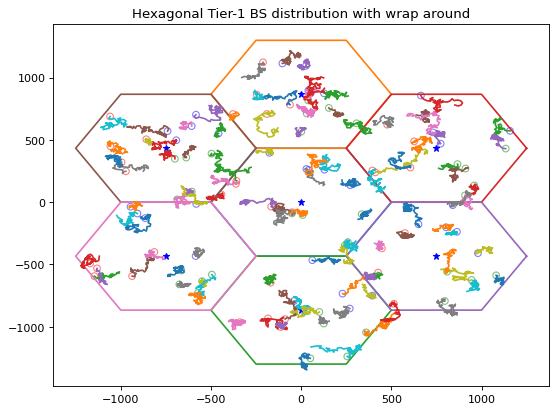

In [17]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)


numm = 5
total_user, xs, ys= GetSecusers(numm)

XX, YY, vel_user = User_Mobility(total_user, xs, ys, 10, 20, 50)
print(np.shape(vel_user))

plt.plot(x1,y1)
plt.plot(x2,y2)                                                                 
plt.plot(x3,y3)
plt.plot(x4,y4)
plt.plot(x5,y5)
plt.plot(x6,y6)
plt.plot(x7,y7)
plt.plot(BS_locations_x,BS_locations_y,'b*')    

#plt.scatter(BS2x, BS2y)
#plt.scatter(BS3x, BS3y)
#plt.scatter(BS4x, BS4y)
#plt.scatter(BS5x, BS5y)
#plt.scatter(BS6x, BS6y)
#plt.scatter(BS7x, BS7y)

plt.title('Hexagonal Tier-1 BS distribution with wrap around')
                                                                                
for i in range(7):
  k =(3*numm)*i
  plt.scatter(xs[k:k+numm], ys[k:k+numm], edgecolor='b', facecolor='none', alpha=0.5)
  plt.scatter(xs[k+numm:k+2*numm], ys[k+numm:k+2*numm], edgecolor='r', facecolor='none', alpha=0.5)
  plt.scatter(xs[k+2*numm:k+3*numm], ys[k+2*numm:k+3*numm], edgecolor='g', facecolor='none', alpha=0.5)


for i in range(total_user):
  plt.plot(XX[:,i], YY[:,i])

plt.show()

# **Path Loss RMA Scenario**

In [20]:
#PL model for RMA scenario

def PathlossRMA(d_2d, d_3d):
  f_c = 2.3 #GHz
  c = 3*pow(10,8) #m/s

  h_ut = 1.5 #m
  h_bs = 35 #m
  h = 5 #m --avg. building height
  W = 20 #m --avg. street width

  d_bp = 2*math.pi*h_bs*h_ut*f_c*pow(10,9)/c

  #LOS probability
  if d_2d <= 10:
    P_los = 1
  else:
    P_los = math.exp(-1*(d_2d-10)/1000)
    
  PL_1 = 20*math.log(40*math.pi*d_3d*f_c/3 , 10) + min(0.03*pow(h, 1.72) , 10)*math.log(d_3d, 10) - min(0.044*pow(h, 1.72) , 14.77) + 0.002*math.log10(h)*d_3d
  PL_2 = PL_1*d_bp + 40*math.log10(d_3d/d_bp)

  #NLOS
  #PL_NLOS = 161.04 - 7.1*math.log10(W) +7.5*math.log10(h) - (24.37-3.7*pow(h/h_bs, 2))*math.log10(h_bs) + (43.42-3.1*math.log10(h_bs))*(math.log10(d_3d)-3) + 20*math.log10(f_c) - (3.2*pow(math.log10(11.75*h_ut) , 2) - 4.97)
  PL_NLOS = 0

  #LOS for prob>0.5
  if P_los >= 0.5:
    if d_2d <= d_bp:
      return PL_1
    elif d_2d > d_bp and d_2d < 10*1000:
      return PL_2

  else: #NLOS for prob<0.5
    if d_2d <= d_bp:
      return max(PL_1, PL_NLOS)
    elif d_2d > d_bp and d_2d < 5000:
      return max(PL_2, PL_NLOS)



# **Path Loss UMA Scenario**

In [21]:
f_c = 2.3 #GHz
c = 3*pow(10,8) #m/s

In [22]:
#PL model for UMA scenario

def PathlossUMA(d_2d, d_3d):
  f_c = 2.3 #GHz
  c = 3*pow(10,8) #m/s
  h_ut = 1.5 #m
  h_bs = 25 #m
  h_e = 1
  h_bs_eff = h_bs - h_e
  h_ut_eff = h_ut - h_e

  d_bp_eff = 4*h_bs_eff*h_ut_eff*f_c*pow(10,9)/c

  #LOS probability
  #for outdoor users
  if d_2d <= 18:
    P_los = 1
  else:
    if h_ut <= 13:
      C_h = 0
    else:
      C_h = pow((h_ut - 13)/10, 1.5)
    
    temp1 = (math.exp(-1*d_2d/63))*(1 - 18/d_2d)
    #temp2 = 1 + C_h*(5/4)*pow(d_2d/100, 3)*math.exp(-d_2d/150)
    temp2 = 1
    P_los = (18/d_2d + temp1)*temp2
    #print(P_los)

  #print(P_los)
  PL_1 = 28 + 22*math.log(d_3d, 10) + 20*math.log(f_c, 10)
  PL_2 = 28 + 40*math.log(d_3d, 10) + 20*math.log(f_c, 10) - 9*math.log(pow(d_bp_eff, 2) + pow(h_bs - h_ut, 2) , 10)
  #PL_NLOS = 13.54 + 39.08*math.log(d_3d, 10) + 20*math.log(f_c, 10) - 0.6*(h_ut - 1.5)
  PL_NLOS = 0

  #LOS for prob>0.5
  if P_los >= 0.5:
    if d_2d <= d_bp_eff:
      return PL_1
    elif d_2d > d_bp_eff and d_2d < 5000:
      return PL_2

  else: #NLOS for prob<0.5
    if d_2d <= d_bp_eff:
      return max(PL_1, PL_NLOS)
    elif d_2d > d_bp_eff and d_2d < 5000:
      return max(PL_2, PL_NLOS)

# Distance Calculations

In [23]:
def getdist(n_users,x,y, time_instants):
  h_bs = 25 #m
  h_ut = 1.5 #m
  h = 5 #avg building height
  h_act = h_bs - h_ut #m

  #distance from each user to base station
  Dr_2d = np.zeros((time_instants, 7*7*3, n_users))

  for t in range(time_instants):
    for i in range(7*7*3):
      for j in range(n_users):
        Dr_2d[t][i][j] = math.sqrt(pow(BS_wrap_around_total3x[i] - x[t][j], 2) + pow(BS_wrap_around_total3y[i] - y[t][j], 2)) 

  Dr_3d = np.zeros((time_instants, 7*7*3, n_users))

  for t in range(time_instants):
    for i in range(7*7*3):
      for j in range(n_users):
        Dr_3d[t][i][j] = math.sqrt(pow(Dr_2d[t][i][j], 2) + pow(h_act, 2))

  return Dr_2d, Dr_3d

# Path Loss Matrix

In [24]:
def PathLoss(dist2d, dist3d, n_users):
  Dr_2d, Dr_3d = dist2d, dist3d
  
  PLr = np.zeros(np.shape(Dr_2d))

  time_instants, row, col = np.shape(Dr_2d)

  #path loss calculation
  for t in range(time_instants):
    for i in range(7*7*3):
      for j in range(n_users):
        #PLr[t][i][j] = PathlossRMA(Dr_2d[t][i][j], Dr_3d[t][i][j])   #for RMA
        PLr[t][i][j] = PathlossUMA(Dr_2d[t][i][j], Dr_3d[t][i][j])   #for UMA
  
  return PLr


In [26]:
def PathLossWrapped(pathloss1):
  time_instant, basest, numusers = np.shape(pathloss1)

  pathloss_wrap = np.zeros((time_instant, basest*3, numusers))

  for t in range(time_instant):
    for i in range(basest):
      if(i==0):
        j = i
      pathloss_wrap[t][j] = np.copy(pathloss1[t][i])
      pathloss_wrap[t][j+1] = np.copy(pathloss1[t][i])
      pathloss_wrap[t][j+2] = np.copy(pathloss1[t][i])
      j = i+3

  return pathloss_wrap

# Log Normal Shadowing

In [28]:
def LogNormShadow(PLr): 
  X = np.random.normal(0,4, np.shape(PLr))  #shape of path loss matrix   #sigma in dB
  log_norm_loss = 1*X  #dB 

  #print(log_norm_loss)
  
  return log_norm_loss

# Fixed Shadowing

In [30]:
def getshadloss(x_mobile, y_mobile): #time_instants x users
    
    X = np.random.normal(0,4, 9)  #dB

    shad_loss = np.zeros(np.shape(x_mobile))
    #fixed_shad = [-0.28322395, 1.21221711, 0.14622614, -0.83883009, -0.13781312, 1.34763206, 0.6653947, 0.06966137, -0.19037237]
    fixed_shad = np.copy(X)
    R = radius
    ISD = math.sqrt(3)*radius
    
    rows, cols = np.shape(x_mobile)
    
    for i in range(rows):
        for j in range(cols):
            x = x_mobile[i][j]
            y = y_mobile[i][j]
            
            if(x>= -3*R and x<= -R and y>= ISD and y<= 3*ISD):
                shad_loss[i][j] = fixed_shad[0]
                
            elif(x>= -R and x<= R and y>= ISD and y<= 3*ISD):
                shad_loss[i][j] = fixed_shad[1]
                
            elif(x>= R and x<= 3*R and y>= ISD and y<= 3*ISD):
                shad_loss[i][j] = fixed_shad[2]
                
            elif(x>= -3*R and x<= -R and y>= -ISD and y<= ISD):
                shad_loss[i][j] = fixed_shad[3]
                
            elif(x>= -R and x<= R and y>= -ISD and y<= ISD):
                shad_loss[i][j] = fixed_shad[4]
                
            elif(x>= R and x<= 3*R and y>= -ISD and y<= ISD):
                shad_loss[i][j] = fixed_shad[5]
                
            elif(x>= -3*R and x<= -R and y>= -3*ISD and y<= -ISD):
                shad_loss[i][j] = fixed_shad[6]
                
            elif(x>= -R and x<= R and y>= -3*ISD and y<= -ISD):
                shad_loss[i][j] = fixed_shad[7]
                
            elif(x>= R and x<= 3*R and y>= -3*ISD and y<= -ISD):
                shad_loss[i][j] = fixed_shad[8]
                
            else:
                shad_loss[i][j] = 0
            
        
    return shad_loss
    

# Correlated Shadowing

In [32]:
def correlated_shadowing(x_mobile, y_mobile, sigma_shd):
    bs_wrap = 49
    D_cor = 100
    #sigma_shd = 100 #dB
    
    Dist_bs = np.zeros((bs_wrap, bs_wrap))
    Corr_bs = np.zeros(np.shape(Dist_bs))
    
    time_steps, num_users = np.shape(x_mobile)
    
    #shadowing matrix dim -> time_steps x base_stations x total_users
    shadowing_mat = np.zeros((time_steps, 147, num_users))

    for m1 in range(bs_wrap):
        for m2 in range(bs_wrap):
            Dist_bs[m1][m2] = np.linalg.norm(BS_cords[:, m1] - BS_cords[:, m2])
            Corr_bs[m1][m2] = np.exp(-np.log(2)*Dist_bs[m1][m2]/D_cor)

    A1 = np.linalg.cholesky(Corr_bs)
    #print(A1)
    
    bsrandom1 = np.random.normal(size = bs_wrap)

    sh_BS = np.matmul(A1, bsrandom1)
    #print(sh_BS) #dim -> total_base_stations

    for m in range(bs_wrap):
        sh_BS[m] = (1/math.sqrt(2))*sigma_shd*sh_BS[m]/np.linalg.norm(A1[m,:])

    #print(sh_BS)

    # for users
    for time in range(time_steps):
        
        time_steps, num_users = np.shape(x_mobile)
        Dist_user = np.zeros((num_users, num_users))
        Corr_user = np.zeros((num_users, num_users))

        for m1 in range(num_users):
            for m2 in range(num_users):
                Dist_user[m1][m2] = np.linalg.norm([x_mobile[time][m1]-x_mobile[time][m2], y_mobile[time][m1]-y_mobile[time][m2]])
                Corr_user[m1][m2] = np.exp(-np.log(2)*Dist_user[m1][m2]/D_cor)

        A2 = np.linalg.cholesky(Corr_user)
        userrandom1 = np.random.normal(size = num_users)
        
        sh_user = np.matmul(A2, userrandom1) #dim -> num_users

        for m in range(num_users):
            sh_user[m] = (1/math.sqrt(2))*sigma_shd*sh_user[m]/np.linalg.norm(A2[m])
        
        #Shadowing Matrix for each time step:
        
        for bs in range(147):
            for user in range(num_users):
                shadowing_mat[time][bs][user] = sh_BS[bs//3] + sh_user[user]
            
    
    #print(shadowing_mat)

    return shadowing_mat

# Directivity Gain and Antenna Gain

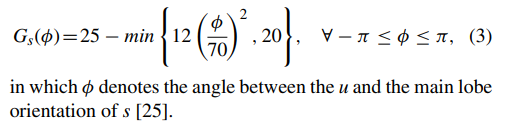

In [36]:
#angle made by user wrt each base station
def UserAngle(mobileuser_x, mobileuser_y, BS_totalx, BS_totaly):
  
  t, user_num = np.shape(mobileuser_x) #time_instant, total_users

  total_bss = len(BS_totalx)

  all_angles = np.zeros((t, total_bss, user_num))
  dx = np.zeros((t, total_bss, user_num))
  dy = np.zeros((t, total_bss, user_num)) 

  for time in range(t):
    for bs in range(total_bss):
      dx[time][bs] = mobileuser_x[time] - BS_totalx[bs]

  for time in range(t):
    for bs in range(total_bss):
      dy[time][bs] = mobileuser_y[time] - BS_totaly[bs]

  
  all_angles = np.arctan2(dy, dx)  #time_instant x base_station x total_users

  return all_angles

In [39]:
#phi calculation
def FindPhi(user_angles):
  user_angles = user_angles*180/math.pi   #radians to degree
  
  t, bs, users = np.shape(user_angles)

  phi = np.zeros((t, bs, users)) #bs = (7*3)*7 = 147 = 49*3

  lobe_angle = np.array([[60,180,-60]*int(bs/3)])
  lobe_angle = lobe_angle.transpose()

  for time in range(t):
    phi[time] = lobe_angle - user_angles[time]


  #phi = lobe_angle - user_angles

  phi = np.where(phi>180, 360-phi, phi)  #convert phi range in -180 to 180 deg i.e., phi = phi>180 ? 360-phi : phi

  return phi*math.pi/180    # degree back to radians


In [41]:
def DirectivityGain(users_phi):
  users_phi = users_phi * 180/math.pi #converts to degree
  dir_gain = 25 - np.minimum(12*np.power(users_phi/70, 2), 20)

  return dir_gain

In [43]:
def AntennaGain(dir_gain):  #ant_gain = k*Direc_gain -> dir_gain(dB) = 10log10(k) + Direc_gain(dB)
  k = 0.5                   #k = antenna efficiency factor
  antenna_gain = 10*math.log10(k) + dir_gain 
  
  return antenna_gain

# **Channel Gain Calculations**

In [45]:
def ChannelGainCalculation(pathloss, shadloss, userangles): #Channel Gain Calculations
    
    users_phi = FindPhi(userangles)
    directivity_gain = DirectivityGain(users_phi)
    
    #channel gain dim -> time_steps x base_stations x users
    
    rchgain = - pathloss + directivity_gain - shadloss
    rchgain_lin = np.power(10, (rchgain)/10) #linear


    return rchgain_lin

# **SINR calculation**

In [47]:
def SINR_b4(channel_gain_matrix):
  #e total transmit power of a BS, Ps = 46dBm
  #dBm to watts
  #Ps = 46dBm--->39.81071706W ---> 10log(39.81071706) = 16dB
  M = 99

  Ps_dbm = 46 #dbm
  
  #dBm TO watts CONVERTER
  Ps_lin = pow(10, (Ps_dbm-30)/10)   #Psdbm is in dBm and Ps_watt in Watts
  Ps_lin = Ps_lin/M

  #watts TO dB CONVERTER
  Ps_dB = 10*math.log10(Ps_lin) #dB

  #calculation in linear then converting to dB
  signal_power_matrix = Ps_lin * channel_gain_matrix[:,0:21, :]


  #NOISE
#------------------------------------------------------------------------------------
  #noise power kTB, kT = -174dBm/Hz, BW = bandwidth       
  #kTB(dBm) = -174 + 10log(BW) 
#------------------------------------------------------------------------------------
  
  noise = -174 + 10*math.log10(180*1000) #dBm         BW = 180KHz                   
  #dBm TO watts CONVERTER
  noise_watt = pow(10, (noise-30)/10)   #noise is in dBm and noise_watt in Watts
  #watts TO dB CONVERTER
  noise_dB = 10*math.log(noise_watt, 10) #dB


  #INTERFERENCE
  interference_matrix = np.zeros(np.shape(channel_gain_matrix[:,0:21, :]))

  intf_time, intf_bs, intf_user = np.shape(interference_matrix)

  total_time, total_base_stations, total_users = np.shape(channel_gain_matrix)

  bs_reference = []

  in_one_cell = total_users#int(total_users/7) #total users in one hex cell

  for k in range(7):
    for i in range(in_one_cell):
      bs_reference.append(k)
  
  bs_reference = np.array(bs_reference)

  #print(np.shape(bs_reference))


  for inft in range(intf_time):
    for bss in range(intf_bs):
      for user in range(intf_user): 
        m = bs_reference[user]
        x_dis = BS_locations_x[m]
        y_dis = BS_locations_y[m]
        for j in range(total_base_stations):
          interference_distance = math.sqrt(pow(x_dis - BS_wrap_around_total3x[j], 2) + pow(y_dis - BS_wrap_around_total3y[j], 2))
          if (j!=bss and  math.floor(interference_distance) <= ISD):
            interference_matrix[inft][bss][user] +=  Ps_lin * channel_gain_matrix[inft][j][user]

 
  #SINR
  interference_plus_noise_matrix = 0.33*interference_matrix + noise_watt

  sinr = signal_power_matrix/interference_plus_noise_matrix  #linear

  sinr_dB = 10*np.log10(sinr) #dBe
  sinr_mean = np.mean(sinr_dB)

  return sinr_dB, signal_power_matrix, interference_plus_noise_matrix


# Predicition for each Model

In [ ]:
from tensorflow.keras.models import load_model


In [ ]:
def dnnpred(dnn_model, data):
    

In [166]:
# Prediction Function
def PredictSinr(data):
    result_dict = {'dnn': {'rmse': 0, 'mae': 0}, 
                   'lstm': {'rmse': 0, 'mae': 0},
                   'transformer': {'rmse': 0, 'mae': 0},
                   'hmm': {'rmse': 0, 'mae': 0},
                   'kf': {'rmse': 0, 'mae': 0},
                   'svr': {'rmse': 0, 'mae': 0},
                   'arima': {'rmse': 0, 'mae': 0},
                  }
    
    result_dict['dnn']['rmse'], result_dict['dnn']['mae'] = [random.randint(1,5) for i in range(2)] #dnnpred(data)
    result_dict['lstm']['rmse'], result_dict['lstm']['mae'] = [random.randint(1,5) for i in range(2)] #lstmpred(data)
    result_dict['transformer']['rmse'], result_dict['transformer']['mae'] = [random.randint(1,5) for i in range(2)] #transformerpred(data)
    result_dict['hmm']['rmse'], result_dict['hmm']['mae'] = [random.randint(1,5) for i in range(2)] #hmmpred(data)
    result_dict['kf']['rmse'], result_dict['kf']['mae'] = [random.randint(1,5) for i in range(2)] #kfpred(data)
    result_dict['svr']['rmse'], result_dict['svr']['mae'] = [random.randint(1,5) for i in range(2)] #svrpred(data)
    result_dict['arima']['rmse'], result_dict['arima']['mae'] = [random.randint(1,5) for i in range(2)] #arimapred(data)
    
    
    
    return result_dict


In [167]:
a = [random.randint(1,6) for i in range(2)]
a

[5, 6]

# **SIMULATION FUNCTION**

In [168]:
#create results dataframe
l = [0, 0]
results_dict = {'DNN': l, 'LSTM': l, 'Transformer': l, 'KF': l, 'HMM': l, 'SVR': l, 'ARIMA': l}
df = pd.DataFrame(data=results_dict, index=['RMSE', 'MAE'])
alist  = [2.0, 1.4]
df['DNN'] = [x/len(alist) for x in alist]

print(df)

      DNN  LSTM  Transformer  KF  HMM  SVR  ARIMA
RMSE  1.0     0            0   0    0    0      0
MAE   0.7     0            0   0    0    0      0


# **SINR with Shadowing**

In [169]:
def getsinrdataset(nums, each_sec, Time_instants, v_min, v_max, std_dev):#nums = total no.of simulations, each_sec = no. of users in each secto 
    for i in range(nums):
        iteration_num = i
        num_users, x, y = GetSecusers(each_sec)  #<----- each_sec amount of users in each sector for 1 iteration
        #PlotSecUsers(num_users, x, y)

        x_mobile, y_mobile, users_velocity = User_Mobility(num_users, x, y, v_min, v_max, Time_instants) #time_instants x total_users

        #doing calculations only for the centre cell
        num_users = each_sec*3
        x_mobile = x_mobile[:, :num_users]
        y_mobile = y_mobile[:, :num_users]

        dist2d, dist3d = getdist(num_users, x_mobile, y_mobile, Time_instants)

        path_loss_wrap = PathLoss(dist2d, dist3d, num_users) #this path loss considers 3 base station in each hex cell

        shadowing = correlated_shadowing(x_mobile, y_mobile, std_dev)

        angles_users = UserAngle(x_mobile, y_mobile, BS_wrap_around_total3x, BS_wrap_around_total3y)

        channel_gain_linear = ChannelGainCalculation(path_loss_wrap, shadowing, angles_users)

        channel_gain_dB = 10*np.log10(channel_gain_linear)

        Sinr_dB,_,_ = SINR_b4(channel_gain_linear)      # time_steps x 21 x 210
        
        if(i==0):
            sinr_dataset = Sinr_dB[:, 0, 0][np.newaxis, :]
        else:
            sinr_dataset = np.concatenate((sinr_dataset, Sinr_dB[:, 0, 0][np.newaxis, :]), axis=0)
            

        return sinr_dataset

In [201]:
def SINRsimulations(nums, each_sec, Time_instants, v_min, v_max, std_dev, df):  #nums = total no.of simulations, each_sec = no. of users in each sector
    sum_dnn = [0, 0] #rmse, ,mae
    sum_lstm = [0, 0]
    sum_transformer = [0, 0]
    sum_hmm = [0, 0]
    sum_kf = [0, 0]
    sum_arima = [0, 0]
    sum_svr = [0, 0]
    
    for i in range(nums):
        iteration_num = i
#         num_users, x, y = GetSecusers(each_sec)  #<----- each_sec amount of users in each sector for 1 iteration
#         #PlotSecUsers(num_users, x, y)

#         x_mobile, y_mobile, users_velocity = User_Mobility(num_users, x, y, v_min, v_max, Time_instants) #time_instants x total_users

#         #doing calculations only for the centre cell
#         num_users = each_sec*3
#         x_mobile = x_mobile[:, :num_users]
#         y_mobile = y_mobile[:, :num_users]

#         dist2d, dist3d = getdist(num_users, x_mobile, y_mobile, Time_instants)

#         path_loss_wrap = PathLoss(dist2d, dist3d, num_users) #this path loss considers 3 base station in each hex cell

#         shadowing = correlated_shadowing(x_mobile, y_mobile, std_dev)

#         angles_users = UserAngle(x_mobile, y_mobile, BS_wrap_around_total3x, BS_wrap_around_total3y)

#         channel_gain_linear = ChannelGainCalculation(path_loss_wrap, shadowing, angles_users)

#         channel_gain_dB = 10*np.log10(channel_gain_linear)

#         Sinr_dB,_,_ = SINR_b4(channel_gain_linear)      # time_steps x 21 x 210(users)
        
        user_sinr = [1,2] #Sinr_dB[:,0,0]
        
        result_dict = PredictSinr(user_sinr)
        
        sum_dnn[0] += result_dict['dnn']['rmse']
        sum_dnn[1] += result_dict['dnn']['mae']
        sum_lstm[0] += result_dict['lstm']['rmse']
        sum_lstm[1] += result_dict['lstm']['mae']
        sum_transformer[0] += result_dict['transformer']['rmse']
        sum_transformer[1] += result_dict['transformer']['mae']
        sum_hmm[0] += result_dict['hmm']['rmse']
        sum_hmm[1] += result_dict['hmm']['mae']
        sum_kf[0] += result_dict['kf']['rmse']
        sum_kf[1] += result_dict['kf']['mae']
        sum_svr[0] += result_dict['svr']['rmse']
        sum_svr[1] += result_dict['svr']['mae']
        sum_arima[0] += result_dict['arima']['rmse']
        sum_arima[1] += result_dict['arima']['mae']
    
    df['DNN'] = [x/nums for x in sum_dnn]
    df['LSTM'] = [x/nums for x in sum_lstm]
    df['Transformer'] = [x/nums for x in sum_transformer]
    df['HMM'] = [x/nums for x in sum_hmm]    
    df['KF'] = [x/nums for x in sum_kf]    
    df['SVR'] = [x/nums for x in sum_svr]
    df['ARIMA'] = [x/nums for x in sum_arima]        
    
    return df

In [243]:
# Function to run simulations -> it returns the RMSE, MAE values for all models in the form of a csv file
# this csv file stores results for each experiment we are performing -> eg. fixed std dev, variable speed and vice versa

class SIM():
    def __init__(self, num, total_time_steps, std_dev, v_min, v_max):
        self.num = num
        self.total_time_steps = total_time_steps
        self.std_dev = std_dev
        self.v_min = v_min
        self.v_max = v_max
        
    def RunSimulations(self, each_sec = 2):
        #create results dataframe
        l = [0, 0]
        results_dict = {'DNN': l, 'LSTM': l, 'Transformer': l, 'KF': l, 'HMM': l, 'SVR': l, 'ARIMA': l}
        df = pd.DataFrame(data=results_dict, index=['RMSE', 'MAE'])

        start = time.time()
        exp_result = SINRsimulations(self.num, each_sec, self.total_time_steps, self.v_min, self.v_max, self.std_dev, df)
        end = time.time()
        
        print(f'Time taken: {(end-start)/60} mins')

        exp_result.to_csv(f'model_results/simulationresult_{std_dev}db_{v_min}to{v_max}mps.csv')

        return exp_result
        
    def getsinrdataset(self, each_sec=1):#nums = total no.of simulations, each_sec = no. of users in each secto 
        for i in range(self.num):
            iteration_num = i
            num_users, x, y = GetSecusers(each_sec)  #<----- each_sec amount of users in each sector for 1 iteration
            #PlotSecUsers(num_users, x, y)

            x_mobile, y_mobile, users_velocity = User_Mobility(num_users, x, y, self.v_min, self.v_max, self.total_time_steps) #time_instants x total_users

            #doing calculations only for the centre cell
            num_users = each_sec*3
            x_mobile = x_mobile[:, :num_users]
            y_mobile = y_mobile[:, :num_users]

            dist2d, dist3d = getdist(num_users, x_mobile, y_mobile, self.total_time_steps)

            path_loss_wrap = PathLoss(dist2d, dist3d, num_users) #this path loss considers 3 base station in each hex cell

            shadowing = correlated_shadowing(x_mobile, y_mobile, self.std_dev)

            angles_users = UserAngle(x_mobile, y_mobile, BS_wrap_around_total3x, BS_wrap_around_total3y)

            channel_gain_linear = ChannelGainCalculation(path_loss_wrap, shadowing, angles_users)

            channel_gain_dB = 10*np.log10(channel_gain_linear)

            Sinr_dB,_,_ = SINR_b4(channel_gain_linear)      # time_steps x 21 x 210

            if(i==0):
                sinr_dataset = Sinr_dB[:, 0, 0][np.newaxis, :]
            else:
                sinr_dataset = np.concatenate((sinr_dataset, Sinr_dB[:, 0, 0][np.newaxis, :]), axis=0)
            
            print(sinr_dataset.shape)

        return sinr_dataset


In [244]:
#result = RunSimulations(num, total_time_steps, std_dev, v_min, v_max)

In [245]:
#Object of the class sim
iterations = 10
timesteps = 1000
std_dev = 4 #dB
v_min = 10 #m/s
v_max = 20 #m/s

sim = SIM(iterations, timesteps, std_dev, v_min, v_max)


In [246]:
testdf = sim.RunSimulations()

Time taken: 0.00010703802108764648 mins


In [247]:
testdf

,DNN,LSTM,Transformer,KF,HMM,SVR,ARIMA
RMSE,2.6,3.5,2.9,3.4,2.8,3.3,2.2
MAE,3.5,2.9,3.4,3.6,3.2,2.9,2.8


In [ ]:
start = time.time()
user_dataset = sim.getsinrdataset()
print(f'Time taken: {(time.time()-start)/60} mins')

(1, 1000)


In [ ]:
user_dataset.shape

In [ ]:
for i in range(iterations):
    plt.plot(user_dataset[i])
    plt.show()